In [ ]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


In [ ]:
Path_data = '/content/drive/MyDrive/Diabetic Retinopathy Detection'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Detection/Healthy')
Mild = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Detection/Mild DR')
Moderate = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Detection/Moderate DR')
Proliferate = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Detection/Proliferate DR')
Severe = os.listdir('/content/drive/MyDrive/Diabetic Retinopathy Detection/Severe DR')

In [ ]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Moderate DR', 'Proliferate DR', 'Mild DR', 'Healthy', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [ ]:
# Get Paths

Path_data = '/content/drive/MyDrive/Diabetic Retinopathy Detection'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/content/drive/MyDrive/Diabetic Retinopathy De...,Moderate DR
1,/content/drive/MyDrive/Diabetic Retinopathy De...,Moderate DR
2,/content/drive/MyDrive/Diabetic Retinopathy De...,Moderate DR
3,/content/drive/MyDrive/Diabetic Retinopathy De...,Moderate DR
4,/content/drive/MyDrive/Diabetic Retinopathy De...,Moderate DR


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Paths').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


,count
Labels,
Healthy,798
Moderate DR,721
Mild DR,301
Proliferate DR,229
Severe DR,151


In [ ]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


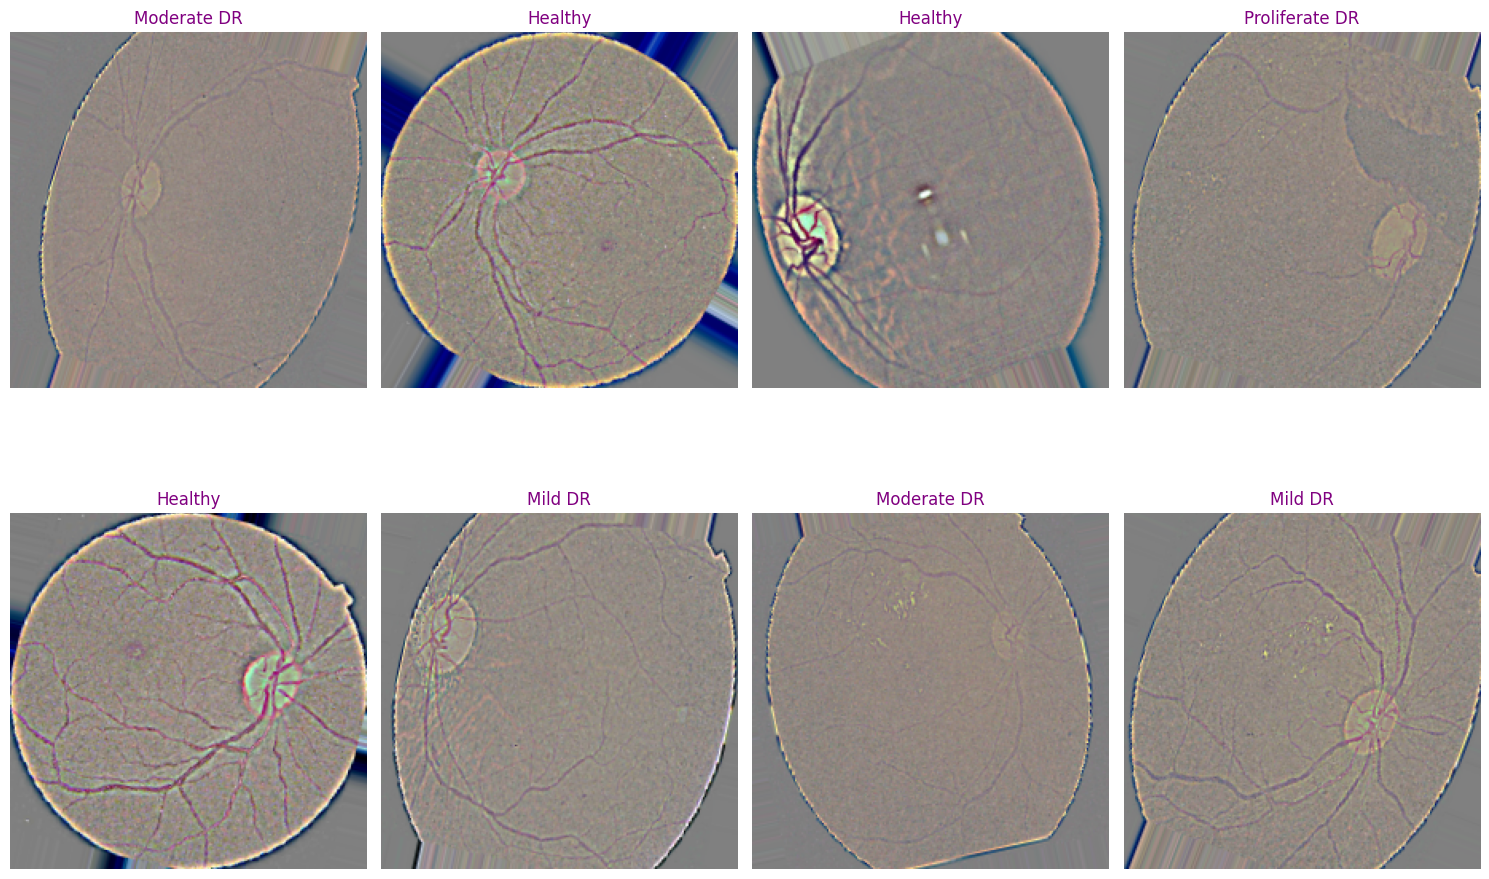

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

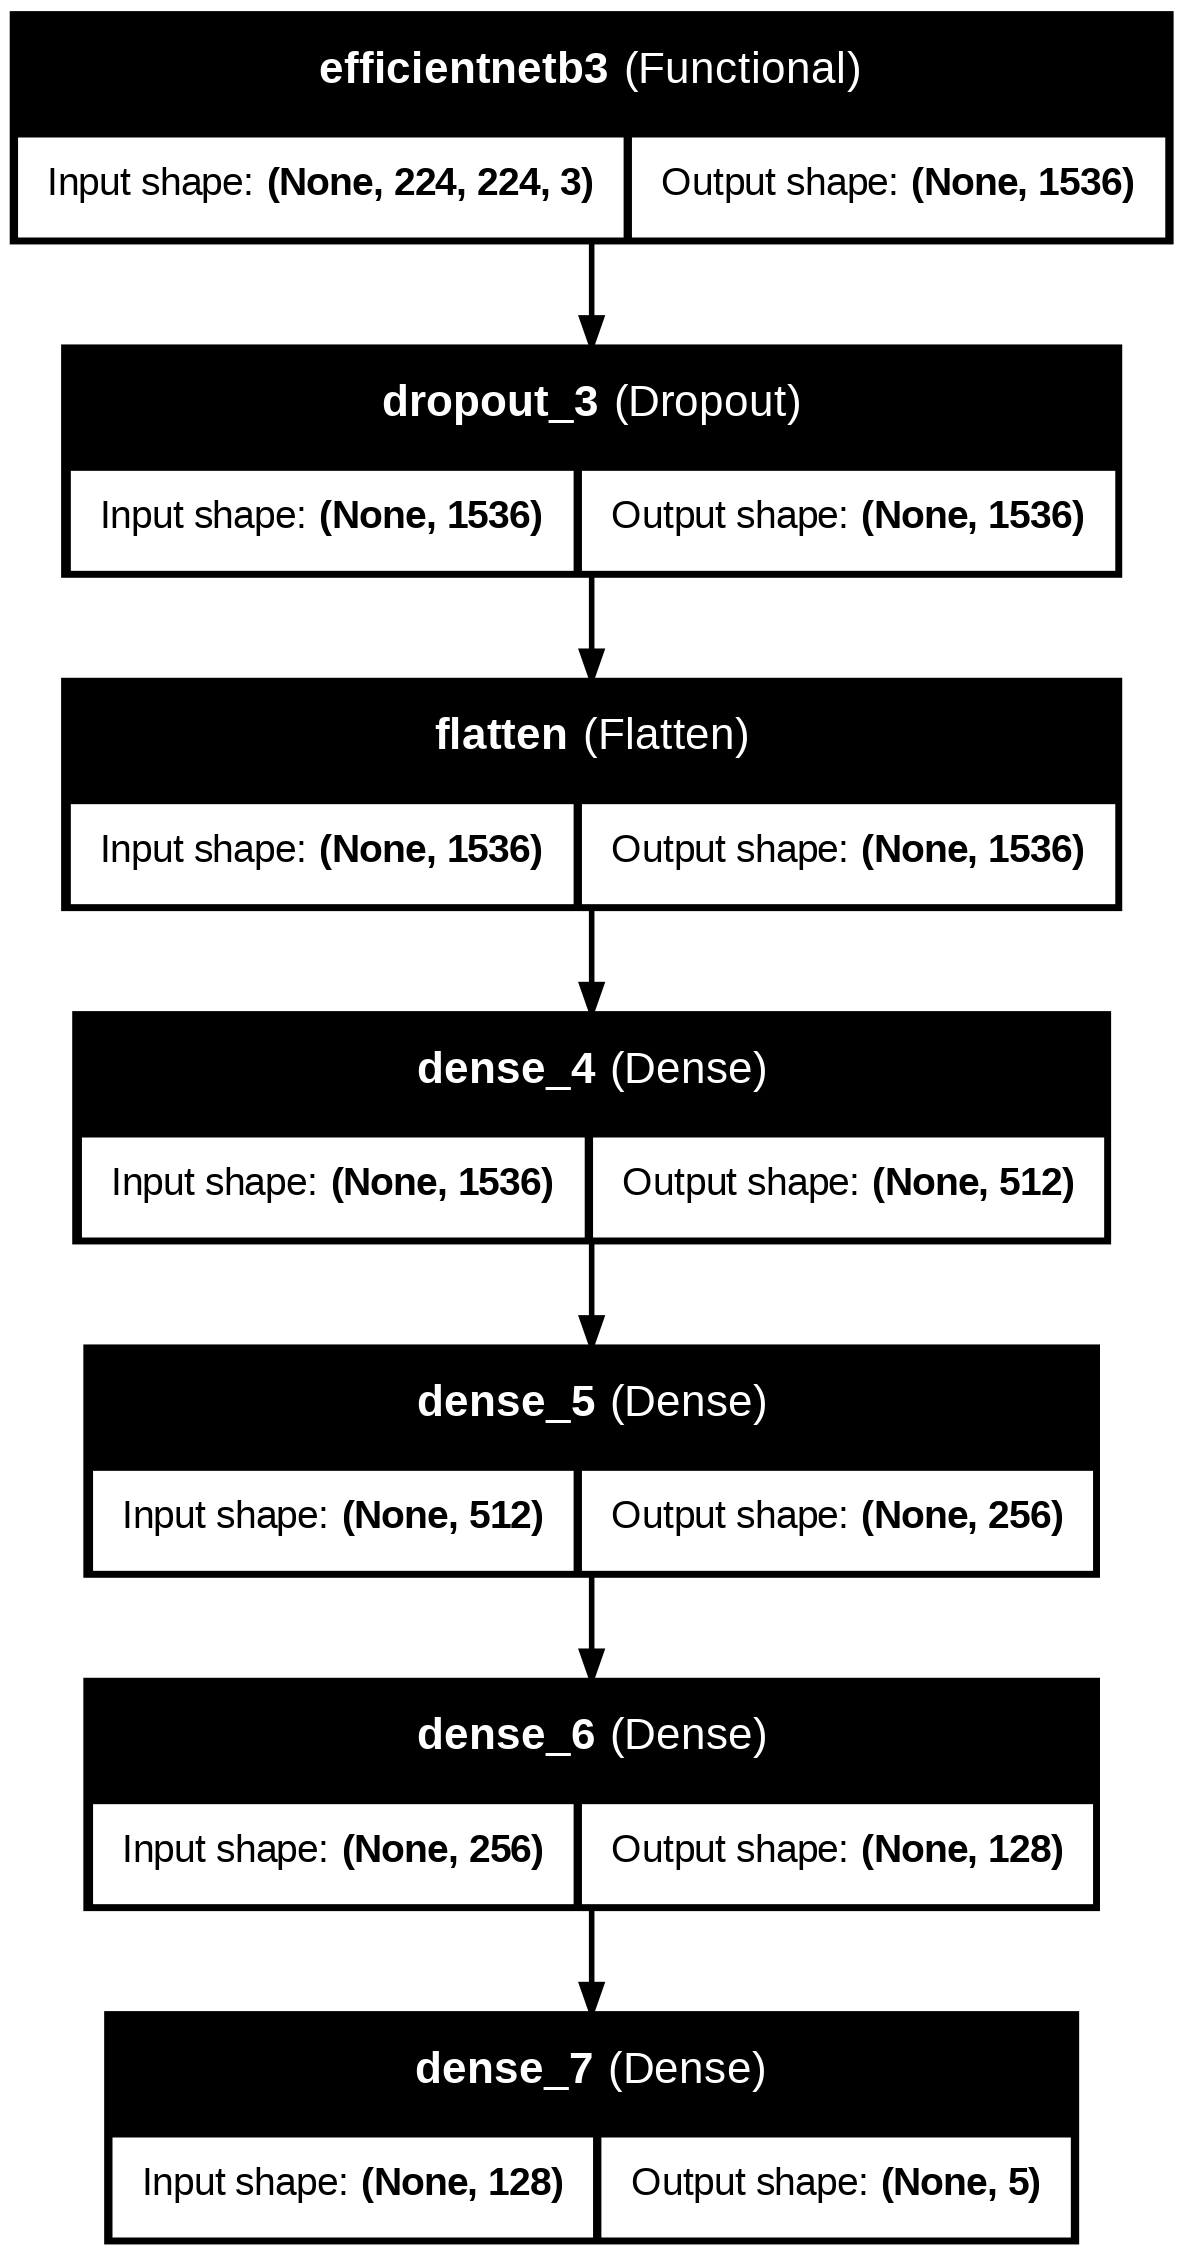

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
epochs = 10
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1573s 13s/step - acc: 0.4215 - loss: 2.0408 - val_acc: 0.4000 - val_loss: 1.6768
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1383s 13s/step - acc: 0.5436 - loss: 1.3198 - val_acc: 0.5927 - val_loss: 1.0906
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1384s 13s/step - acc: 0.5913 - loss: 1.1239 - val_acc: 0.6255 - val_loss: 0.9649
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1376s 13s/step - acc: 0.6105 - loss: 1.0518 - val_acc: 0.6073 - val_loss: 0.9735
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1419s 13s/step - acc: 0.6304 - loss: 1.0144 - val_acc: 0.6291 - val_loss: 0.9903
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1400s 13s/step - acc: 0.6807 - loss: 0.8508 - val_acc: 0.6655 - val_loss: 0.8757
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1397s 13s/step - acc: 0.6868 - loss: 0.8176 - val_acc: 0.6873 - val_loss: 0.8325
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1409s 13s/step - acc: 0.7002 - loss: 0.7846 - val_acc: 0.6873 - val_loss: 0.8618
Epoch 9/10
110/110 ━━━━━━━━━━━━━

In [ ]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

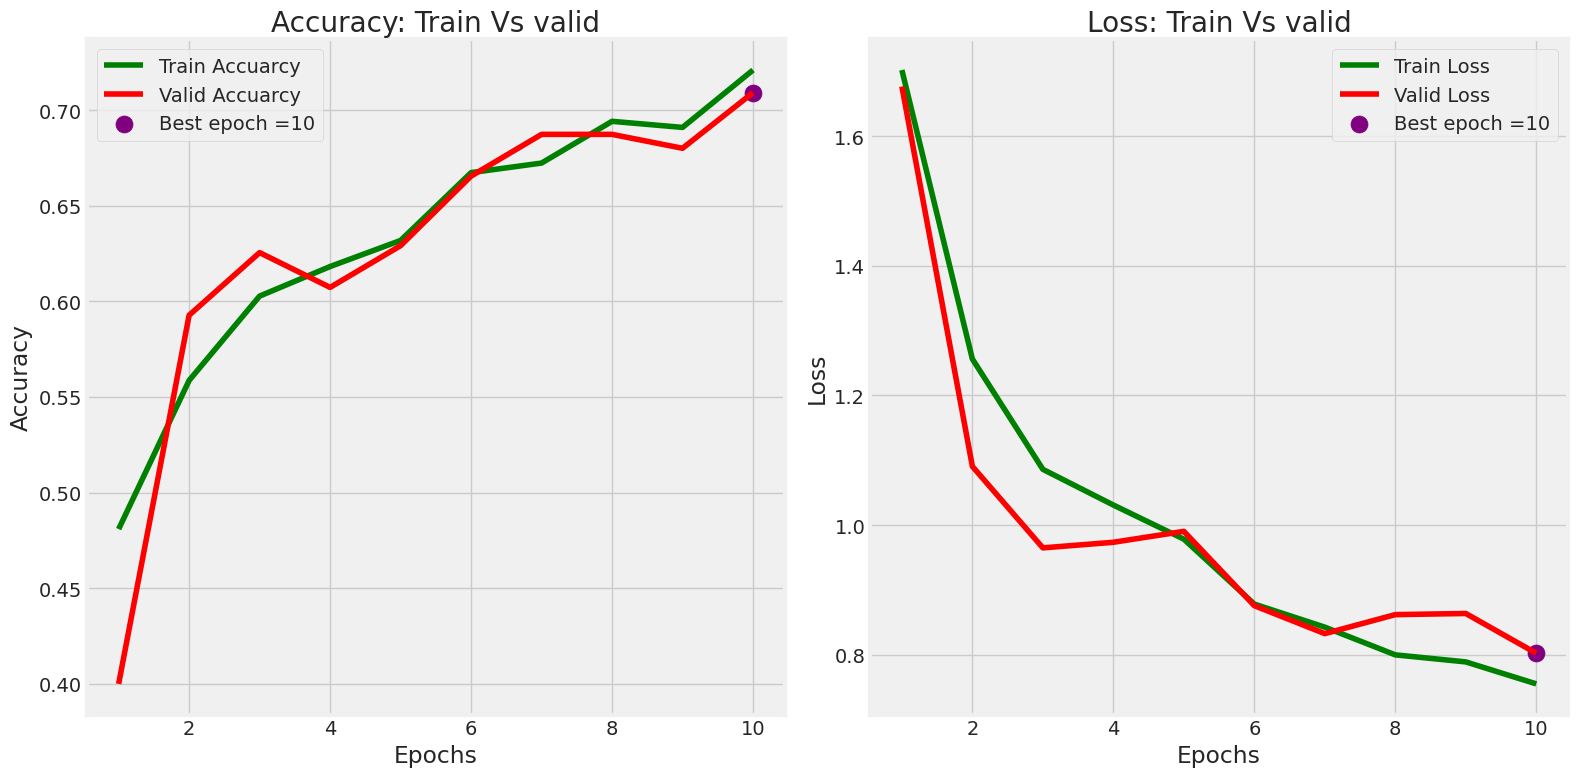

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - acc: 0.7789 - loss: 0.5846
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - acc: 0.6927 - loss: 0.7688
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - acc: 0.7169 - loss: 0.7959
Train Scores : 
    accuracy: 0.7668181657791138 
      Loss:  0.600870668888092 
________________________
Valid Scores : 
    accuracy: 0.7090908885002136 
      Loss:  0.8022193312644958 
________________________
Test Scores : 
    accuracy: 0.7163636088371277 
      Loss:  0.7715340852737427 
________________________


In [26]:
predictions = model.predict(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step
[[1.1200804e-03 1.7294262e-02 8.0234301e-01 6.7503557e-02 1.1173908e-01]
 [4.3211525e-04 1.0988664e-02 9.3037635e-01 4.0169168e-02 1.8033622e-02]
 [9.9292821e-01 1.7123739e-03 4.1614976e-03 4.2348570e-04 7.7439169e-04]
 ...
 [9.8588902e-01 5.5530029e-03 7.7348966e-03 6.4671127e-04 1.7632989e-04]
 [1.2862773e-03 8.1948936e-02 8.0420250e-01 6.5277450e-02 4.7284763e-02]
 [9.9969923e-01 5.3152995e-05 2.3303783e-04 5.3522308e-06 9.2545224e-06]]
[2 2 0 0 0 2 0 0 2 2 0 2 2 1 0 0 0 0 1 2 1 0 2 0 0 0 0 0 0 0 0 1 2 2 2 1 0
 0 0 0 2 2 0 2 0 0 2 0 2 2 0 0 1 2 0 2 1 1 0 2 2 0 1 2 2 1 0 2 2 0 2 2 1 2
 2 0 2 0 2 2 0 0 0 0 2 2 2 2 0 0 1 0 4 0 1 0 2 0 0 1 0 1 2 0 2 2 2 2 2 2 0
 2 1 2 2 0 2 2 0 0 2 0 2 0 0 2 2 0 2 0 2 0 2 0 0 1 2 2 1 2 2 1 2 2 2 2 2 1
 2 0 2 2 2 1 0 2 2 0 0 2 0 0 0 1 0 1 2 2 0 2 0 2 0 1 2 2 2 2 0 0 2 2 0 2 2
 2 2 2 0 0 0 1 2 2 2 2 0 0 2 0 0 0 2 2 2 2 0 0 0 2 2 2 0 0 2 2 0 2 0 2 1 1
 0 2 0 2 2 1 1 2 1 2 2 2 2 0 0 0 0 2 2 2 2 1 2 0 2 2 0 2 1 0 0 0 2 

In [27]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[102,   2,   1,   0,   0],
       [  4,  18,  12,   0,   0],
       [  2,   7,  76,   0,   0],
       [  1,   5,  26,   0,   0],
       [  1,   1,  16,   0,   1]])

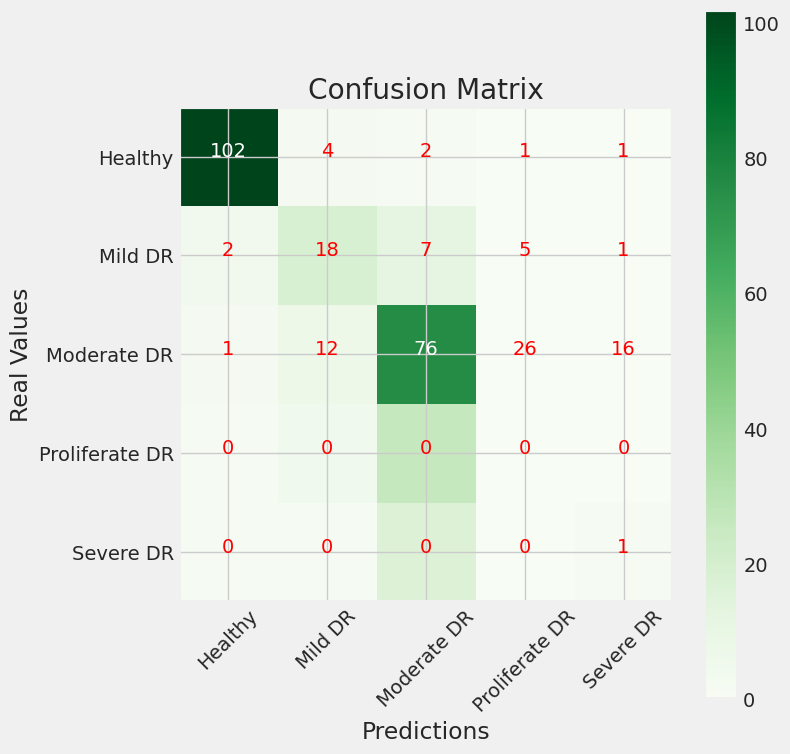

In [28]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [29]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

                precision    recall  f1-score   support

       Healthy       0.93      0.97      0.95       105
       Mild DR       0.55      0.53      0.54        34
   Moderate DR       0.58      0.89      0.70        85
Proliferate DR       0.00      0.00      0.00        32
     Severe DR       1.00      0.05      0.10        19

      accuracy                           0.72       275
     macro avg       0.61      0.49      0.46       275
  weighted avg       0.67      0.72      0.65       275



In [30]:
model.save('effB3 CNN DR.h5')